## Transformer
- rnn 기반 신경망 사용하지 않고 encoder-decoder 구조를 attention만으로 구현한 모델
- rnn보다 우수한 성능보임
- Encoder
  - multi-head self-attention
  - positional-wise ffnn
- Decoder
  - masked multi-head self-attention
  - multi-head attention(encoder-decoder)
  - positional-wise ffnn


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

### 1.Positional Encoding
- transformer는 병렬연산을 하기 때문에 각 시퀀서 위치정보를 순차적으로 받을 수 없기 때문에 다르게 단어 위치를 알려주는 방식
- 기존 임베딩 벡터 + 포지셔널인코딩
  - 포지셔널 인코딩은 각 시퀀스의 위치, 차원이 짝수(sin), 홀수(cos)인지에 따라 구해짐
  - 이렇게 포지셔널 인코딩을 구하면 기존 임베딩 벡터에 더함 -> 크기는 그대로


In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    #짝수에 sin함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    #홀수에 cos함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines #sin 적용하고
    angle_rads[:, 1::2] = cosines #cos 적용하고
    pos_encoding = tf.constant(angle_rads) #합쳐랏
    pos_encoding = pos_encoding[tf.newaxis, ...] #텐서의 차원을 확장 -> 첫번째 차원에 새로운 축을 추가하고 ... 은 나머지 모든 차원을 그대로 유지하라는 의미

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32) #텐서를 새로운 형태로 캐스팅 (pos_encoding -> 실수형으로)

  def call(self, inputs):
    # inputs가 sparsetensor일 경우 밀집 텐서로 변환
    if isinstance(inputs, tf.sparse.SparseTensor):
            inputs = tf.sparse.to_dense(inputs)

    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :] #inputs 값에 맞는 임베딩 벡터 + 포지셔널인코딩 불러오는 함수
    # : 은 첫번재 차원 (전체 배치) 선택
    # :tf.shape(inputs)[1] 은 두번째 차원에서 현재 시퀀스 길이만큼의 포지셔널 인코딩을 선택
    # : 은 마지막 차원인 'd_model'을 모두 선택

포지셔널 인코딩 행렬을 시각화하면 어떻게 생겼나?

(1, 50, 128)


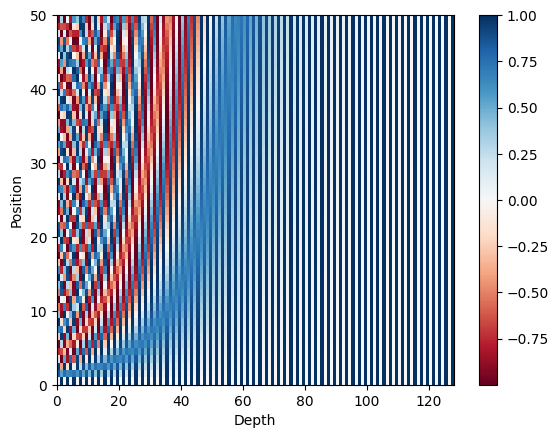

In [ ]:
# 문장의 길이 50, 임베딩 벡터의 차원 128 일때 이케 생김
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### 2.Scaled dot-product attention
- attention 계산할 때 사용

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. attention score matrix를 구해보자~
  matmul_qk = tf.matmul(query, key, transpose_b=True) #내적진행
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth) #루트(k의 차원개수)로 나눔

  #마스킹 진행 (인코더에서는 패딩, 디코더에서는 패딩, 룩어헤드)
  if mask is not None:
    logits+=(mask*-1e9)

  attention_weights = tf.nn.softmax(logits, axis=-1) #attention score에 softmax 함수 적용
  output = tf.matmul(attention_weights, value) #value와 내적 진행 후 가중합 진행

  return output, attention_weights

임의로 값을 넣어서 값 구해보자

In [ ]:
# 임의의 Query, Key, Value인 Q, K, V 행렬 생성
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

# 함수 실행
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열) (attention score에 softmax 적용한거)
# query는 key 값 중 2번쨰것과 비슷하므로 결과가 0, 1, 0, 0 이 나옴

print(temp_out) # 어텐션 값
# 결과적으로 value의 두번쨰 값이 출력되는 것을 확인할 수 있음

tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [ ]:
# 임의의 Query, Key, Value인 Q, K, V 행렬 생성
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)

print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
# 세번쨰 값, 네번째 값 두개의 값과 유사하다는 의미 나옴

print(temp_out) # 어텐션 값
# 결과적으로 나오는 값 [550, 5.5]는 Value의 세번째 값 [100, 5]에 0.5를 곱한 값과
# 네번째 값 [1000, 6]에 0.5를 곱한 값의 원소별 합임

tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [ ]:
# 하나가 아닌 3개의 query의 값을 함수의 입력으로 사용
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)

print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


### 3.Encoder

#### 3-1. Multi-head Attention
- self attention으로 positional encoding된 행렬을 query, key, value로 나눠 scaled-dot-product attention 수행
- multi-head 로 수행하기 위해 d_model/num_heads 개수로 나눠 수행 (각 num_heads에 attention 수행)
- attention이 수행된 num_heads를 모두 concatenate하여 w0를 곱해주면 multi-head attention 완료

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    #Python의 'assert'문을 사용하여 조건이 참인지 확인하는 코드
    #이 조건이 참이 아닐 경우 AssertionError 발생함
    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

#### 3-2. Padding Mask
- attention score matrix의 0은 <PAD> 토큰끼리의 유사도로 어떤 유의미한값도 없음

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
#패딩 마스크 적용되면 어떻게 되나~?
print(create_padding_mask(tf.constant([[1, 21, 777, 0, 0]])))

#위 벡터를 스케일드 닷 프로덕트 어텐션의 인자로 전달하면
# 스케일드 닷 프로덕트 어텐션에서는 위 벡터에다가 매우 작은 음수값인 -1e9를 곱하고
# 이를 행렬에 더해주어 해당 열을 전부 마스킹한다!!!!

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


#### 3-3. Position-wise FFNN
- 완전연결신경망이라 할 수 있음
- 앞의 멀티헤드 어텐션 결과에 가중치와 편향을 더해 이를 활성화 함수를 거쳐 다시 가중치와 편향을 더함
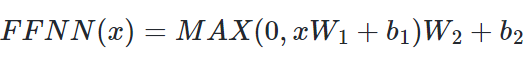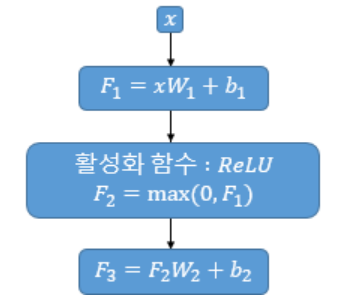

In [ ]:
# 다음의 코드는 인코더와 디코더 내부에서 사용되는데 이케 생겼다
# outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
# outputs = tf.keras.layers.Dense(units=d_model)(outputs)

#### 3-4. Residual connection & Layer Normalization
- 잔차연결
  - x의 입력과 출력을 더해주는 방식
  - H(x) = x + Multi-head Attention(x)
- 층 정규화
  - 각 단어 시퀀스의 차원을 기준으로 각각 평균과 분산을 구해 정규화 진행
  - LN=LayerNorm(x+H(x))


#### 3-5. Encoder 구현

In [ ]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

#### 3-6. Encoder 쌓기
- num_layers 개 만큼 쌓기

In [ ]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 4. Decoder
- Masked multi-head self attention
  - look-ahead mask 진행
- encoder-decoder multi-head attention
- position-wise ffnn

#### 4-1. Masked multi-head attention
- 셀프 어텐션 진행
- 룩-어헤드 마스크 진행
  - 트랜스포머는 문장을 각 시점마다 순차적으로 입력받는 것이 나닌 한번에 입력받음. 그래서 현재 시점의 단어를 예측하고자 할때 미래 시점의 단어까지도 참고할 수 가 있음
  - 이를 방지하기 위해 마스킹 진행

In [ ]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))
# 룩어헤드 + 패딩 마스크 진행 완료

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


#### 4-2. Encoder-Decoder multi-head attention
- self 아님
- encoder에서 key, value 값으로 사용하고 decoder에서 query로 사용함
- multi-head로 처리함


#### 4-3. Decoder 구현
- 총 3개의 서브층 구현
- 서브층 연산 후에는 드롭아웃, 잔차연결, 층정규화가 수행됨

In [ ]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")

  # 패딩 마스크(두번째 서브층)
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

#### 4-4. Decoder 쌓기
- num_layers 만큼 쌓기

In [ ]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### 5. 트랜스포머 구현하기!!!
- 인코더와 디코더 조합하여 만들어보자
- 디코더 끝단에 다중 클래스 분류 문제 풀수 있도록 vocab_size 만큼의 뉴런을 가지는 출력층 추가

In [ ]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

하이퍼파라미터 임의로 정하기

(1, 9000, 128)
(1, 9000, 128)


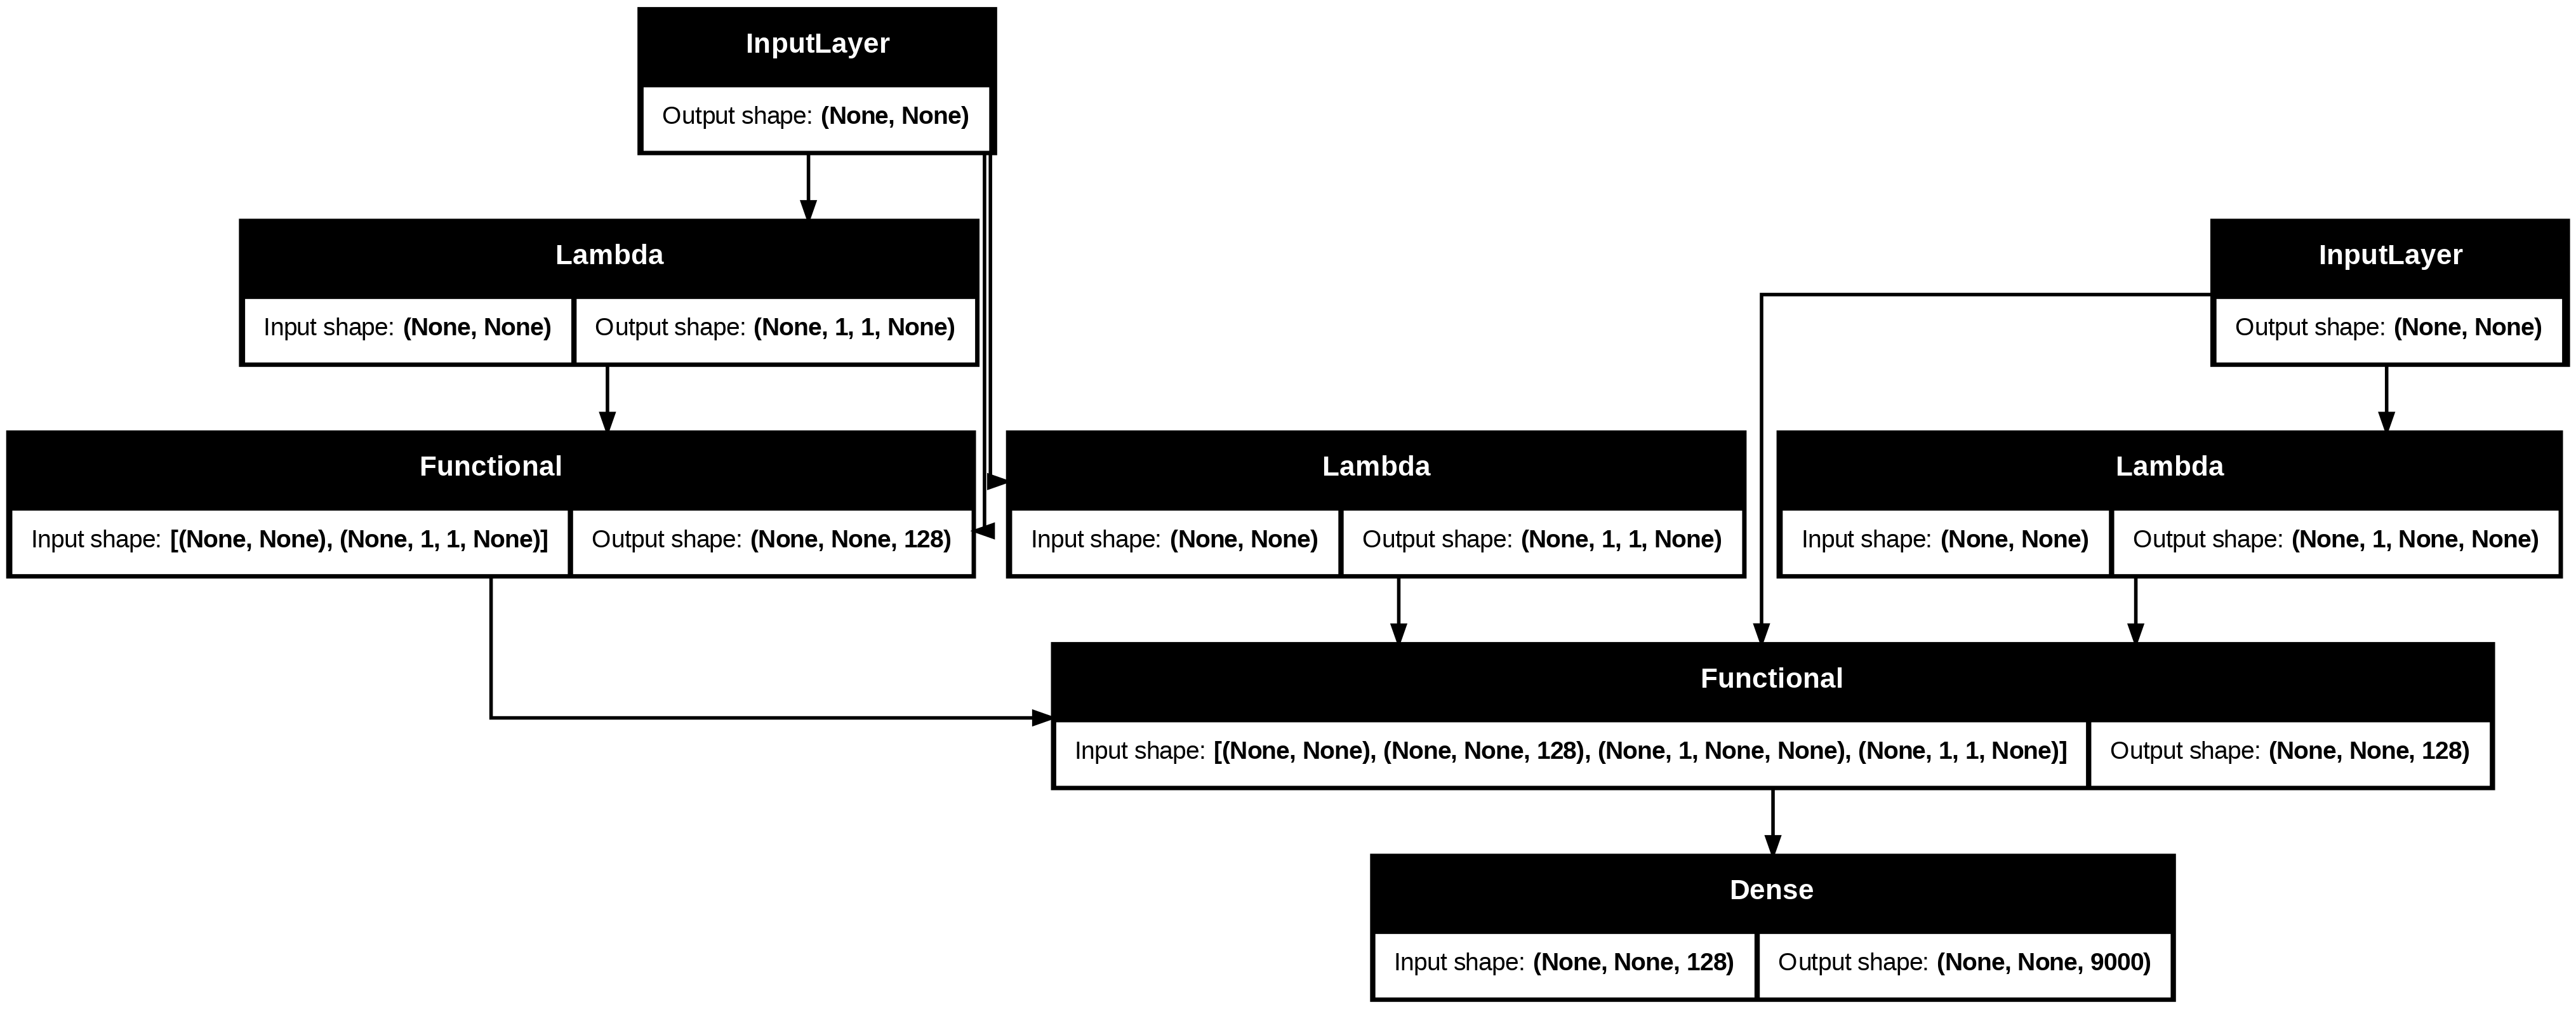

In [ ]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True)

In [ ]:
print(tf.__version__)

# 위의 코드에서 positional encoding 부분의 call()에서 오류남
# 왜냐? inputs 매개변수로 전달된 텐서가 희소 텐서 형태이므로. keras 모델은 일반적으로 밀집 텐서를 기대한다
# 그래서 if 문 추가
# 텐서 버전 2.x인 경우 tf.sparse.is_sparse 대신 tf.sparse.experimental.is_sparse를 사용

2.17.0


손실함수 정의

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

학습률
- 트랜스포머의 경우 학습률 사용자가 정한 단계까지 증가시키다가 그에 이르면 점차 떨어트리는 방법 사용함

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

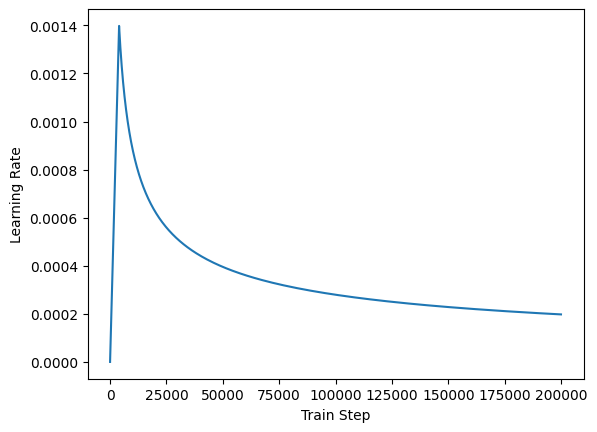

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 여기서 구현한 트랜스포머 모델 바탕으로 한국어 챗봇 구현 (다음 챕터에서)

논문에 언급되지 않은 트랜스포머 구현 이야기
https://tunz.kr/post/4